In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


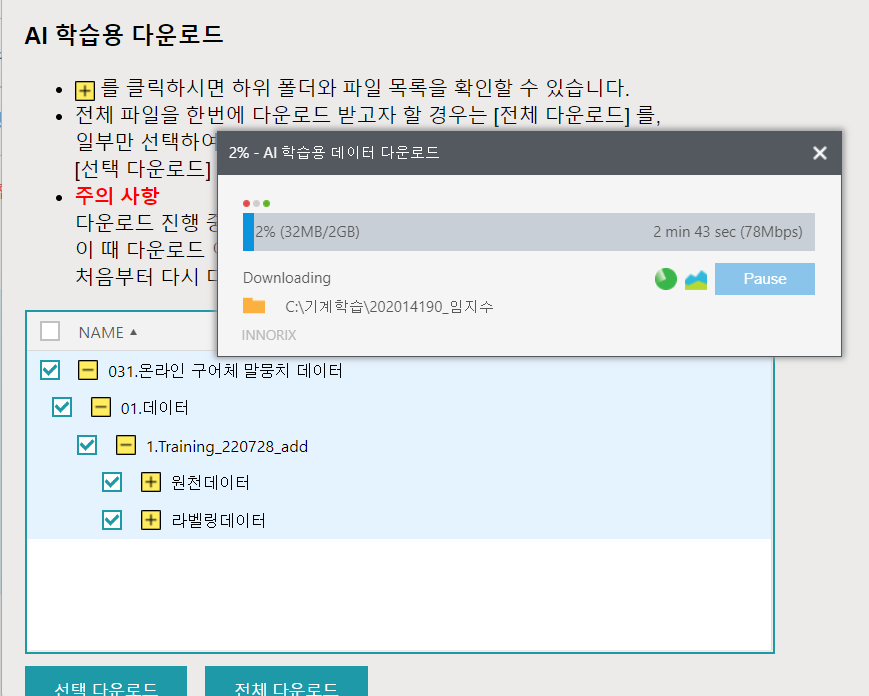

In [2]:
from torch.utils.data import (DataLoader, TensorDataset)
from torch import nn
from tqdm import tqdm
import numpy as np
import torch
import os

class TransformerChat(nn.Module):

    def __init__(self, config):
        super().__init__()

        # 전체 단어(음절) 개수
        self.vocab_size = config["vocab_size"]

        # 단어(음절) 벡터 크기
        self.embedding_size = config['embedding_size'] # 임베딩 벡터사이즈, vocab 사이즈만큼 있어야 함

        # Transformer의 Attention Head 개수
        self.num_heads = config['num_heads'] # head를 몇개로 할 건지

        # transformer 몇 층 쌓을 지
        # Transformer Encoder의 Layer 수
        self.num_encoder_layers = config['num_encoder_layers']

        # Transformer Decoder의 Layer 수
        self.num_decoder_layers = config['num_decoder_layers']

        # 입력 Sequence의 최대 길이
        self.max_length = config['max_length'] 

        # Transformer 내부 FNN 크기
        self.hidden_size = config['hidden_size']

        # Token Embedding Matrix 선언
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)

        # Transformer Encoder-Decoder 설계(선언)
        self.transformer = nn.Transformer(d_model=self.embedding_size, nhead=self.num_heads, num_encoder_layers=self.num_encoder_layers,
                                          num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.hidden_size)
       
        # 입력 길이 L에 대한 (L X L) mask 생성: 이전 토큰들의 정보만을 반영하기 위한 mask
        #       [[1, -inf, -inf, -inf],
        #        [1,    1, -inf, -inf],
        #               ......
        #        [1,    1,    1,    1]]
        # 이곳을 채우세요.
        self.mask = self.transformer.generate_square_subsequent_mask(self.max_length).cuda()
        # 전체 단어 분포로 변환하기 위한 linear
        # 이곳을 채우세요.
        self.projection_layer = nn.Linear(self.embedding_size,self. vocab_size)

    def forward(self, enc_inputs, dec_inputs):

        # enc_inputs: [batch, seq_len], dec_inputs: [batch, seq_len]
        # enc_input_features: [batch, seq_len, emb_size] -> [seq_len, batch, emb_size]
        # 이곳을 채우세요.
        enc_input_features = self.embeddings(enc_inputs).transpose(0,1) # 인코더의 입력
        # dec_input_features: [batch, seq_len, emb_size] -> [seq_len, batch, emb_size]
        # 이곳을 채우세요.
        dec_input_features = self.embeddings(dec_inputs).transpose(0,1) # 디코더의 입력

        # dec_output_features: [seq_len, batch, emb_size]
        dec_output_features = self.transformer(src=enc_input_features, tgt=dec_input_features, src_mask = self.mask, tgt_mask = self.mask)

        # output 나온 걸 vocab size만큼 projection
        # hypothesis : [seq_len, batch, vocab_size]
        hypothesis = self.projection_layer(dec_output_features)

        return hypothesis

In [3]:
# 어휘사전(vocabulary) 생성 함수
def load_vocab(file_dir):

    with open(file_dir,'r',encoding='utf8') as vocab_file:
        char2idx = {}
        idx2char = {}
        index = 0
        for char in vocab_file:
            char = char.strip()
            char2idx[char] = index
            idx2char[index] = char
            index+=1

    return char2idx, idx2char

# 문자 입력열을 인덱스로 변환하는 함수
def convert_data2feature(config, input_sequence, char2idx, decoder_input=False):

    # 나머지는 0으로 패드 채우기
    # 고정 길이 벡터 생성
    input_features = np.zeros(config["max_length"], dtype=np.int)

    if decoder_input:
        # Decoder Input은 Target Sequence에서 Right Shift
        # Target Sequence :         ["안","녕","하","세","요", "</S>" ] -> dec_output
        # Decoder Input Sequence :  ["<S>", "안","녕","하","세","요"] -> dec_input
        # 이곳을 채우세요.
        input_sequence = " ".join(["<S>"] + input_sequence.split()[:-1])

    for idx,token in enumerate(input_sequence.split()):
        if token in char2idx.keys():
            input_features[idx] = char2idx[token]
        else:
            input_features[idx] = char2idx['<UNK>']

    return input_features

# 데이터 읽기 함수
def load_dataset(config):

    # 어휘사전 읽어오기
    char2idx, idx2char = load_vocab(config['vocab_file'])

    file_dir = config['train_file']
    data_file = open(file_dir,'r',encoding='cp949').readlines()

    # 데이터를 저장하기 위한 리스트 생성
    enc_inputs, dec_inputs, dec_outputs = [], [], []

    for line in tqdm(data_file):

        line = line.strip().split('\t')

        input_sequence = line[0]
        output_sequence = line[1]

        enc_inputs.append(convert_data2feature(config, input_sequence, char2idx)) # 숫자열로 바꿔 인코더 인풋에 넣음
        dec_inputs.append(convert_data2feature(config, output_sequence, char2idx, True)) # 디코더 입력은 스타트 심볼 주고 한번씩 미뤄야 해서 True
        dec_outputs.append(convert_data2feature(config, output_sequence, char2idx)) # 디코더 출력은 원래 문장대로

    # 전체 데이터를 저장하고 있는 리스트를 텐서 형태로 변환
    enc_inputs = torch.tensor(enc_inputs, dtype=torch.long)
    dec_inputs = torch.tensor(dec_inputs, dtype=torch.long)
    dec_outputs = torch.tensor(dec_outputs, dtype=torch.long)

    return enc_inputs, dec_inputs, dec_outputs, char2idx, idx2char

In [4]:
# 텐서를 리스트로 변환하는 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

## 평가
def do_test(config, model, word2idx, idx2word, input_sequence="오늘 약속있으세요?"):

    # 평가 모드 셋팅
    model.eval()

    # 입력된 문자열의 음절을 공백 단위 토큰으로 변환. 공백은 <SP>로 변환: "오늘 약속" -> "오 늘 <SP> 약 속"
    input_sequence = " ".join([e if e != " " else "<SP>" for e in input_sequence])

    # 텐서 변환: [1, seq_len]
    enc_inputs = torch.tensor([convert_data2feature(config, input_sequence, word2idx)], dtype=torch.long).cuda()
    
    # 디코딩 할 때 스타트 심볼 넣음
    # input_ids : [1, seq_len] -> 첫번째 디코더 입력 "<S>" 만들기    batch_size=1
    # True라 하면 한 칸 옆으로 가고 <S> 넣음
    dec_inputs = torch.tensor([convert_data2feature(config, "", word2idx, True)], dtype=torch.long).cuda()
    
    # 시스템 응답 문자열 초기화
    response = ''

    # 최대 입력 길이 만큼 Decoding Loop
    for decoding_step in range(config['max_length']-1):

        # dec_outputs: [vocab_size]
        dec_outputs = model(enc_inputs, dec_inputs)[decoding_step, 0, :]
        # 가장 큰 출력을 갖는 인덱스 얻어오기
        dec_output_idx = np.argmax(tensor2list(dec_outputs))

        # 생성된 토큰은 dec_inputs에 추가 (첫번째 차원은 배치)
        dec_inputs[0][decoding_step+1] = dec_output_idx

        # </S> 심볼 생성 시, Decoding 종료
        # </S> 나올때까지 앞의 과정을 계속 반복
        if idx2word[dec_output_idx] == "</S>":
            break

        # 생성 토큰 추가
        response += idx2word[dec_output_idx]
    
    # <SP>를 공백으로 변환한 후 응답 문자열 출력
    print(response.replace("<SP>", " "))

def test(config):

    # 어휘사전 읽어오기
    word2idx, idx2word = load_vocab(config['vocab_file'])

    # Transformer Seq2Seq 모델 객체 생성
    model = TransformerChat(config).cuda()

    # 학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir"], config["trained_model_name"])))

    while(True):
        input_sequence = input("문장을 입력하세요. (종료는 exit을 입력하세요.) : ")
        if input_sequence == 'exit':
            break
        do_test(config, model, word2idx, idx2word, input_sequence)

In [5]:
def train(config):

    # Transformer Seq2Seq 모델 객체 생성
    model = TransformerChat(config).cuda()

    # 데이터 읽기
    enc_inputs, dec_inputs, dec_outputs, word2idx, idx2word = load_dataset(config)

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    train_features = TensorDataset(enc_inputs, dec_inputs, dec_outputs)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # 크로스엔트로피 손실 함수
    loss_func = nn.CrossEntropyLoss()

    # 옵티마이저 함수 지정
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learn_rate"])

    for epoch in range(config["epoch"] + 1):

        for (step, batch) in enumerate(train_dataloader):

            # 학습 모드 셋팅
            model.train()
          
            # batch = (enc_inputs[step], dec_inputs[step], dec_outputs)*batch_size
            # .cuda()를 통해 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)

            # 역전파 변화도 초기화
            optimizer.zero_grad()

            enc_inputs, dec_inputs, dec_outputs = batch

            # hypothesis: [seq_len, batch, vocab_size] -> [seq_len*batch, vocab_size]
            # 이곳을 채우세요.
            hypothesis = model(enc_inputs, dec_inputs).view(-1, config['vocab_size'])

            ## 모양을 맞춰주는 과정
            # labels: [batch, seq_len] -> [seq_len, batch] -> [seq_len(max_length)*batch] # transformer에서 seq_len과 batch 위치가 뒤집혀 있어서 여기서 바꿈
            labels = dec_outputs.transpose(0, 1)
            labels = labels.reshape(config["max_length"]*dec_inputs.size(0)) # 1차원 형태로

            # 비용 계산 및 역전파 수행: cross_entopy 내부에서 labels를 원핫벡터로 변환 (골드레이블은 항상 1차원으로 입력)
            loss = loss_func(hypothesis, labels)
            loss.backward()
            optimizer.step()

            # 200 배치마다 중간 결과 출력
            if (step+1)% 200 == 0:
                print("Current Step : {0:d} / {1:d}\tCurrent Loss : {2:f}".format(step+1, int(len(enc_inputs) / config['batch_size']), loss.item()))
                # 생성 문장을 확인하기 위한 함수 호출
                # do_test(config, model, word2idx, idx2word)

        # 에폭마다 가중치 저장
        torch.save(model.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

In [19]:
import gc
import torch
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/colab/transformer/chatbot/"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    config = {"mode": "train",
              "vocab_file": os.path.join(root_dir, "vocab.txt"),
              "train_file": os.path.join(root_dir, "pre_sampling.txt"),
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir":output_dir,
              "epoch": 5,
              "learn_rate":0.00005,
              "num_encoder_layers": 6,
              "num_decoder_layers": 6,
              "num_heads": 4,
              "max_length": 25,
              "batch_size": 128,
              "embedding_size": 256,
              "hidden_size": 512,
              "vocab_size": 4427
            }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 10000/10000 [00:00<00:00, 34118.20it/s]


In [20]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/colab/transformer/chatbot/"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    config = {"mode": "test",
              "vocab_file": os.path.join(root_dir, "vocab.txt"),
              "train_file": os.path.join(root_dir, "pre_sampling.txt"),
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir":output_dir,
              "epoch": 5,
              "learn_rate":0.00005,
              "num_encoder_layers": 6,
              "num_decoder_layers": 6,
              "num_heads": 4,
              "max_length": 25,
              "batch_size": 128,
              "embedding_size": 256,
              "hidden_size": 512,
              "vocab_size": 4427
            }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

문장을 입력하세요. (종료는 exit을 입력하세요.) : 루디 퐁키 정말 눈에 담아보고 싶당


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


퐁키 귀여워요
문장을 입력하세요. (종료는 exit을 입력하세요.) : 아 귀여워요
퐁키 귀여워요
문장을 입력하세요. (종료는 exit을 입력하세요.) : 프사 어떻게 다운로드 하셨나요
퐁키 귀여워요
문장을 입력하세요. (종료는 exit을 입력하세요.) : exit
